In [ ]:
from torch.utils.data import DataLoader, Dataset
from collections import Counter
from torchvision import datasets
from experiment import tune_architecture, resume_tuning, plot_losses
from preprocessing import visualize_images, verify_image_sizes, plot_bar, TestDataset
from model import Model, train, predict

import torch
import pandas as pd
import torchvision.transforms as transforms
import os


## Data analysis and preprocessing

In [2]:
basic_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [3]:
dataset = datasets.ImageFolder("data/train", transform=basic_transforms)
analysis_loader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=2)
classes = dataset.classes

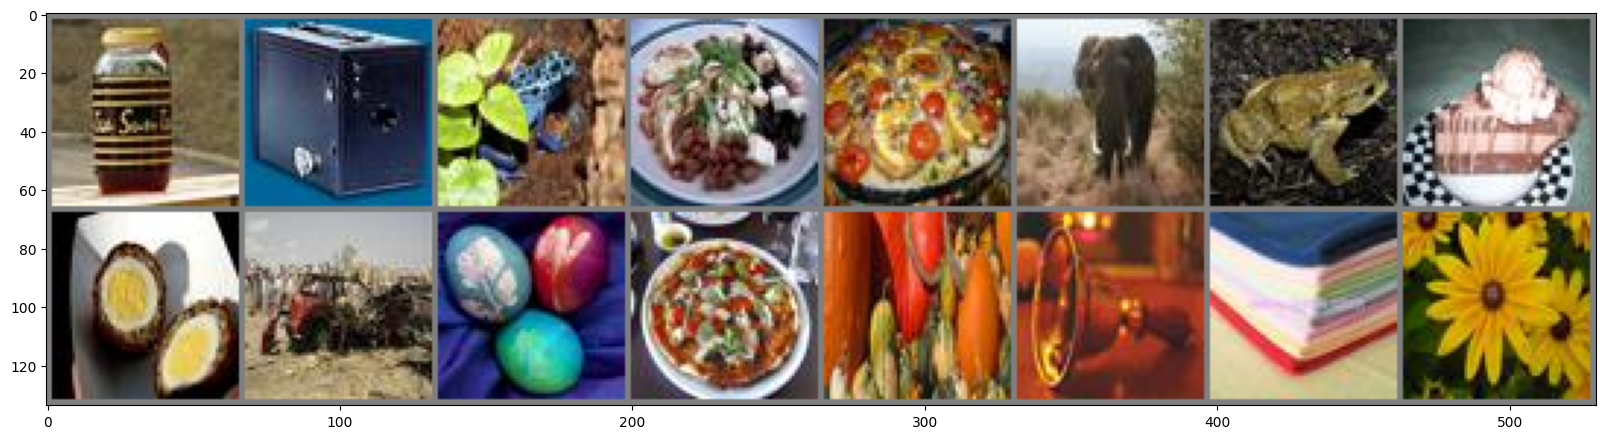

  tea camera  frog  bean icecream elephant  frog icecream   egg  bomb   egg pizza squash acoustic towel flower


In [4]:
visualize_images(analysis_loader, classes, figsize=(20,10))

In [5]:
# verify_image_sizes(analysis_loader)

All images are 64x64 pixels with three color channels (RGB).

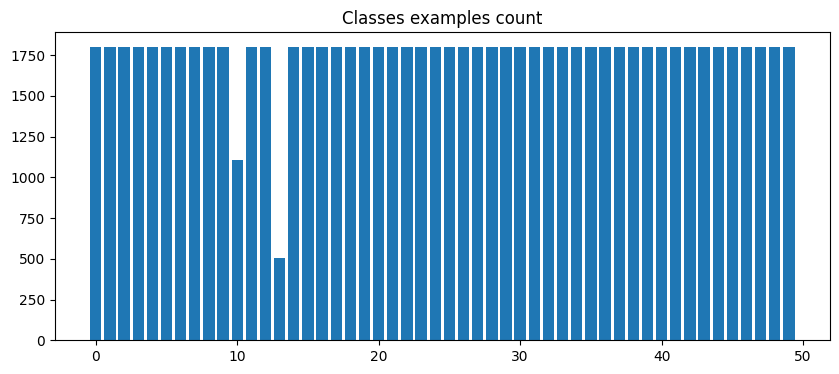

In [ ]:
class_examples_num = dict(Counter(dataset.targets))
plot_bar(class_examples_num, "Classes examples count",  size=(10, 4))

In [7]:
print(f"{classes[10]}: {class_examples_num[10]}, {classes[13]}: {class_examples_num[13]}")


bread: 1108, carbon: 503


Dataset is nearly completely balanced at 1800 examples for almost all classes. Only class 10 (bread) and class 13(carbon) have respectively 1108 and 503 examples.

In [8]:
print("Dataset size: ", len(dataset))
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
print("Train set size: ", len(train_dataset))
print("Validation set size: ", len(val_dataset))

Dataset size:  88011
Train set size:  70408
Validation set size:  17603


In [9]:
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation(24),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
train_dataset.dataset.transform = train_transforms

# Model and training

In [12]:
conv_architectures = [
        [
                {"conv": (3, 32, 3, 2, 1), "batch_norm": 32, "activation": True, "max_pool": (2, 2)}, #32->16
                {"conv": (32, 64, 3, 1, 1), "batch_norm": 64, "activation": True, "max_pool": (2, 2)}, #16->8
                {"flatten": True},
                {"linear": (8*8*64, 256), "activation": True},
                {"dropout": 0.5, "linear": (256, 50)}
        ],
        [
                {"conv": (3, 64, 5, 1, 2), "batch_norm": 64, "activation": True, "max_pool": (2, 2)}, #64->32
                {"conv": (64, 128, 3, 1, 1), "batch_norm": 128, "activation": True, "max_pool": (2, 2)}, #32->16
                {"conv": (128, 256, 3, 1, 1), "batch_norm": 256, "activation": True, "max_pool": (2, 2)}, #16->8
                {"flatten": True},
                {"linear": (8*8*256, 128), "activation": True},
                {"dropout": 0.5, "linear": (128, 50)}
        ],
        [
                {"conv": (3, 32, 7, 1, 1), "batch_norm": 32, "activation": True, "max_pool": (2, 2)}, #60->30
                {"conv": (32, 64, 3, 1, 1), "batch_norm": 64, "activation": True, "max_pool": (2, 2)}, #30->15
                {"conv": (64, 128, 3, 1, 1), "batch_norm": 128, "activation": True, "max_pool": (2, 2)}, #15->7
                {"flatten": True},
                {"linear": (7*7*128, 256), "activation": True},
                {"dropout": 0.5, "linear": (256, 50)}
        ],
]

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
training_setup = {"epochs": 15, "lr": 3e-4, "batch_size": 128, "class_weights": None}
conv_losses, conv_train_accuracy, conv_train_precision, conv_train_recall, conv_train_f1, conv_train_confusion_matrix, conv_train_roc_curve, conv_val_accuracy, conv_val_precision, conv_val_recall, conv_val_f1, conv_val_confusion_matrix, conv_val_roc_curve = tune_architecture(train_dataset, val_dataset, conv_architectures, training_setup, device, verbose=True, save_weights=True)

Training model 0
Epoch: 0, loss: 3.7273828204444013
Epoch: 1, loss: 3.4721636287529973
Epoch: 2, loss: 3.3431280710736115
Epoch: 3, loss: 3.2723096793013777
Epoch: 4, loss: 3.22123975978789
Epoch: 5, loss: 3.180588757710535
Epoch: 6, loss: 3.147264970841728
Epoch: 7, loss: 3.1259163031777106
Epoch: 8, loss: 3.1102294813699602
Epoch: 9, loss: 3.0870262486099547
Epoch: 10, loss: 3.0750278240972335
Epoch: 11, loss: 3.0677969152827878
Epoch: 12, loss: 3.052932165495497
Epoch: 13, loss: 3.044685138332
Epoch: 14, loss: 3.038103017530078
Training done


C:\Users\asz-0\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\asz-0\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\asz-0\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

              precision    recall  f1-score   support

           0       0.14      0.13      0.13       374
           1       0.20      0.38      0.26       360
           2       0.27      0.13      0.17       375
           3       0.26      0.13      0.17       374
           4       0.27      0.15      0.19       367
           5       0.41      0.25      0.31       358
           6       0.24      0.42      0.31       365
           7       0.22      0.12      0.15       358
           8       0.20      0.04      0.07       349
           9       0.32      0.24      0.27       363
          10       0.36      0.06      0.10       218
          11       0.23      0.46      0.31       341
          12       0.24      0.50      0.33       361
          13       0.00      0.00      0.00       102
          14       0.19      0.27      0.22       370
          15       0.12      0.03      0.05       347
          16       0.21      0.05      0.08       368
          17       0.18    

C:\Users\asz-0\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\asz-0\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\asz-0\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       374
           1       0.00      0.00      0.00       360
           2       0.00      0.00      0.00       375
           3       0.00      0.00      0.00       374
           4       0.00      0.00      0.00       367
           5       0.00      0.00      0.00       358
           6       0.00      0.00      0.00       365
           7       0.00      0.00      0.00       358
           8       0.00      0.00      0.00       349
           9       0.00      0.00      0.00       363
          10       0.00      0.00      0.00       218
          11       0.00      0.00      0.00       341
          12       0.00      0.00      0.00       361
          13       0.00      0.00      0.00       102
          14       0.00      0.00      0.00       370
          15       0.00      0.00      0.00       347
          16       0.00      0.00      0.00       368
          17       0.00    

C:\Users\asz-0\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.20      0.12      0.15       374
           1       0.39      0.33      0.35       360
           2       0.31      0.15      0.20       375
           3       0.25      0.15      0.19       374
           4       0.27      0.33      0.30       367
           5       0.32      0.36      0.34       358
           6       0.34      0.52      0.41       365
           7       0.26      0.04      0.07       358
           8       0.15      0.01      0.02       349
           9       0.33      0.27      0.30       363
          10       0.22      0.02      0.03       218
          11       0.28      0.59      0.38       341
          12       0.38      0.39      0.38       361
          13       0.00      0.00      0.00       102
          14       0.27      0.35      0.30       370
          15       0.16      0.08      0.11       347
          16       0.14      0.04      0.06       368
          17       0.20    

In [22]:
conv_architecture_results = pd.DataFrame({"models": conv_architectures, "train accuracy": conv_train_accuracy, "train precision": conv_train_precision, "train recall": conv_train_recall, "train f1": conv_train_f1, "val accuracy": conv_val_accuracy, "val precision": conv_val_precision, "val recall": conv_val_recall, "val f1": conv_val_f1})
conv_architecture_results

,models,train accuracy,train precision,train recall,train f1,val accuracy,val precision,val recall,val f1
0,"[{'conv': (3, 32, 3, 2, 1), 'batch_norm': 32, ...",0.281829,0.263337,0.275751,0.247933,0.270749,0.251782,0.265813,0.238821
1,"[{'conv': (3, 64, 5, 1, 2), 'batch_norm': 64, ...",0.020992,0.000420,0.020000,0.000822,0.018292,0.000366,0.020000,0.000719
2,"[{'conv': (3, 32, 7, 1, 1), 'batch_norm': 32, ...",0.322946,0.299082,0.315826,0.288932,0.305857,0.280624,0.299767,0.273057


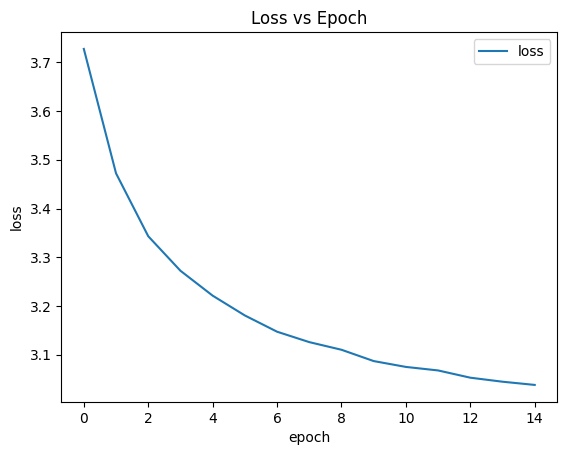

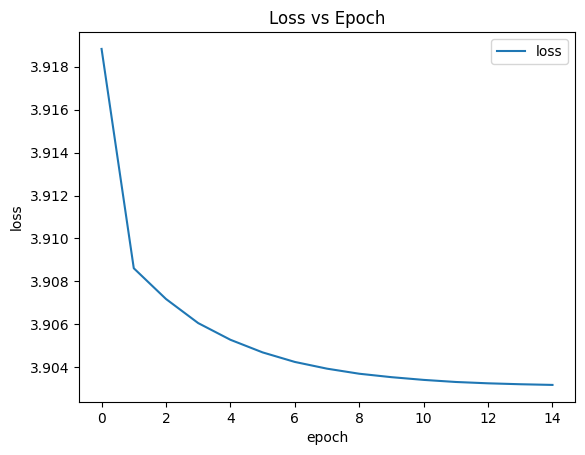

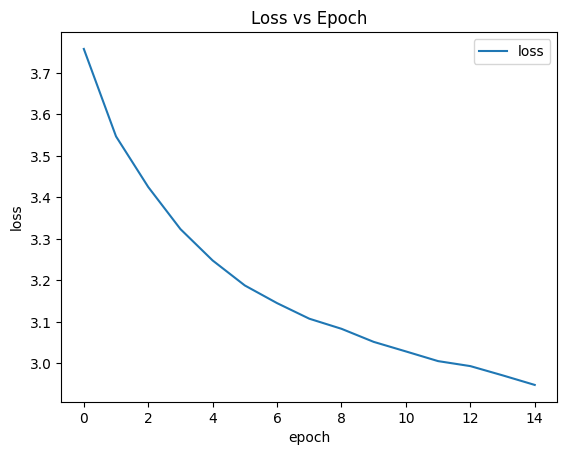

In [57]:
plot_losses(conv_losses)

In [19]:
residual_architectures = [
        # [
        #         {"conv": (3, 64, 7, 1, 3), "batch_norm": 64, "activation": True, "max_pool": (2, 2)}, #64->64->32
        #         {"residual": [
        #                 {"conv": (64, 64, 3, 1, 1), "batch_norm": 64, "activation": True}, #32->32
        #                 {"conv": (64, 64, 3, 1, 1), "batch_norm": 64},  #32->32
        #         ]},
        #         {"activation": True},
        #         {"residual": [
        #                 {"conv": (64, 128, 3, 2, 1), "batch_norm": 128, "activation": True}, #32->16
        #                 {"conv": (128, 128, 3, 1, 1), "batch_norm": 128}, #16->16
        #         ]},
        #         {"activation": True},
        #         {"residual": [
        #                 {"conv": (128, 256, 3, 2, 1), "batch_norm": 256, "activation": True}, #16->8
        #                 {"conv": (256, 256, 3, 1, 1), "batch_norm": 256}, #8->8
        #         ]},
        #         {"activation": True},
        #         {"avg_pool": (8, 8)}, #8->1
        #         {"flatten": True},
        #         {"dropout": 0.5, "linear": (256, 50)},
        # ],
		[
                {"conv": (3, 64, 7, 1, 3), "batch_norm": 64, "activation": True, "max_pool": (2, 2)}, #64->64->32
                {"residual": [
                        {"conv": (64, 64, 3, 1, 1), "batch_norm": 64, "activation": True}, #32->32
                        {"conv": (64, 64, 3, 1, 1), "batch_norm": 64},  #32->32
                ]},
                {"activation": True},
                {"residual": [
                        {"conv": (64, 128, 3, 1, 1), "batch_norm": 128, "activation": True}, #32->32
                        {"conv": (128, 128, 3, 1, 1), "batch_norm": 128}, #32->32
                ]},
                {"activation": True},
                {"residual": [
                        {"conv": (128, 256, 3, 2, 1), "batch_norm": 256, "activation": True}, #32->16
                        {"conv": (256, 256, 3, 1, 1), "batch_norm": 256}, #16->16
                ]},
                {"residual": [
                        {"conv": (256, 512, 3, 2, 1), "batch_norm": 512, "activation": True}, #16->8
                        {"conv": (512, 512, 3, 1, 1), "batch_norm": 512}, #8->8
                ]},
                {"activation": True},
                {"avg_pool": (8, 8)}, #8->1
                {"flatten": True},
                {"dropout": 0.5, "linear": (512, 50)},
        ]
]

In [20]:
training_setup = {"epochs": 15, "lr": 3e-4, "batch_size": 128, "class_weights": None}
res_losses, res_train_accuracy, res_train_precision, res_train_recall, res_train_f1, res_train_confusion_matrix, res_train_roc_curve, res_val_accuracy, res_val_precision, res_val_recall, res_val_f1, res_val_confusion_matrix, res_val_roc_curve = tune_architecture(train_dataset, val_dataset, residual_architectures, training_setup, device, verbose=True, save_weights=True)

Training model 0
Epoch: 0, loss: 3.367906361006998
Epoch: 1, loss: 2.9042431698087774
Epoch: 2, loss: 2.6509303774028856
Epoch: 3, loss: 2.4723497064490068
Epoch: 4, loss: 2.3267049666108757
Epoch: 5, loss: 2.210782378208832
Epoch: 6, loss: 2.1101521710086
Epoch: 7, loss: 2.020755340745791
Epoch: 8, loss: 1.9414058443422542
Epoch: 9, loss: 1.8794128853699257
Epoch: 10, loss: 1.8190763392595544
Epoch: 11, loss: 1.7649800156508513
Epoch: 12, loss: 1.7133942444398054
Epoch: 13, loss: 1.664843126779892
Epoch: 14, loss: 1.6288680281699677
Training done
              precision    recall  f1-score   support

           0       0.35      0.48      0.41       374
           1       0.72      0.45      0.55       360
           2       0.55      0.59      0.57       375
           3       0.43      0.54      0.48       374
           4       0.47      0.58      0.52       367
           5       0.76      0.59      0.66       358
           6       0.80      0.62      0.70       365
           7 

In [23]:
res_architecture_results = pd.DataFrame({"models": residual_architectures, "train accuracy": res_train_accuracy, "train precision": res_train_precision, "train recall": res_train_recall, "train f1": res_train_f1, "val accuracy": res_val_accuracy, "val precision": res_val_precision, "val recall": res_val_recall, "val f1": res_val_f1})
res_architecture_results

,models,train accuracy,train precision,train recall,train f1,val accuracy,val precision,val recall,val f1
0,"[{'conv': (3, 64, 7, 1, 3), 'batch_norm': 64, ...",0.58749,0.60748,0.583003,0.583001,0.550474,0.570953,0.547913,0.54682


In [37]:
training_setup = {"epochs": 15, "lr": 3e-4, "batch_size": 128, "class_weights": None}
con_res_losses, con_res_train_accuracy, con_res_train_precision, con_res_train_recall, con_res_train_f1, con_res_train_confusion_matrix, con_res_train_roc_curve, con_res_val_accuracy, con_res_val_precision, con_res_val_recall, con_res_val_f1, con_res_val_confusion_matrix, con_res_val_roc_curve = resume_tuning("models/res/model_t_ar_0.pt", train_dataset, val_dataset, residual_architectures[0], training_setup, device, verbose=True, save_weights=True)

c:\Users\asz-0\Desktop\NN\Neural-Networks\lab3\model.py:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path))


Training model
Epoch: 0, loss: 1.5913231167299995
Epoch: 1, loss: 1.5536034293269938
Epoch: 2, loss: 1.5198279132427623
Epoch: 3, loss: 1.4907260499286132
Epoch: 4, loss: 1.459636139350448
Epoch: 5, loss: 1.4403170691211513
Epoch: 6, loss: 1.4016079604084826
Epoch: 7, loss: 1.3749456493261722
Epoch: 8, loss: 1.3564033549407433
Epoch: 9, loss: 1.3327292058948164
Epoch: 10, loss: 1.303962040834548
Epoch: 11, loss: 1.28446065535779
Epoch: 12, loss: 1.267743739804858
Epoch: 13, loss: 1.2469146487500837
Epoch: 14, loss: 1.223101132686255
Training done
              precision    recall  f1-score   support

           0       0.47      0.56      0.51       374
           1       0.70      0.56      0.62       360
           2       0.62      0.63      0.62       375
           3       0.68      0.45      0.54       374
           4       0.61      0.57      0.59       367
           5       0.80      0.69      0.74       358
           6       0.75      0.79      0.77       365
           7  

In [39]:
con_res_architecture_results = pd.DataFrame({"models": residual_architectures, "train accuracy": con_res_train_accuracy, "train precision": con_res_train_precision, "train recall": con_res_train_recall, "train f1": con_res_train_f1, "val accuracy": con_res_val_accuracy, "val precision": con_res_val_precision, "val recall": con_res_val_recall, "val f1": con_res_val_f1})
con_res_architecture_results

,models,train accuracy,train precision,train recall,train f1,val accuracy,val precision,val recall,val f1
0,"[{'conv': (3, 64, 7, 1, 3), 'batch_norm': 64, ...",0.687706,0.701659,0.684189,0.68469,0.616088,0.629239,0.613304,0.61233


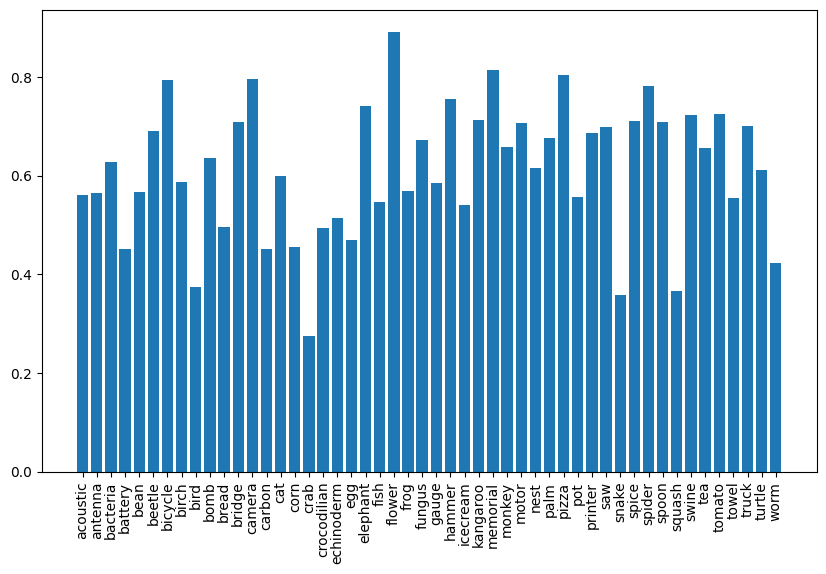

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

cm = con_res_val_confusion_matrix[0]
accuracy_per_class = (cm.astype('float') / cm.sum(axis=1, keepdims=True)).diagonal()
plt.figure(figsize=(10, 6))
plt.bar(np.arange(len(accuracy_per_class)), accuracy_per_class)
plt.xticks(ticks = np.arange(len(classes)), labels=classes, rotation=90)
plt.show()

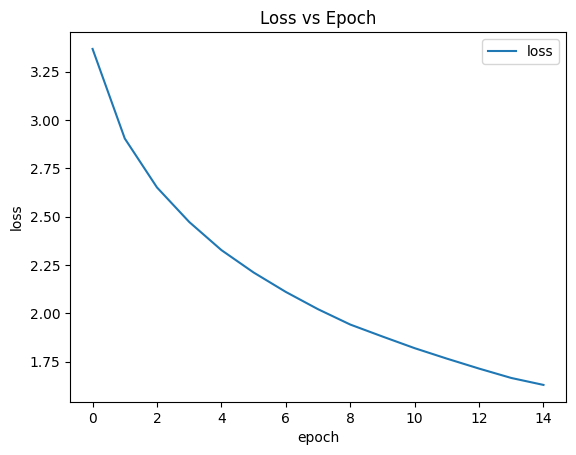

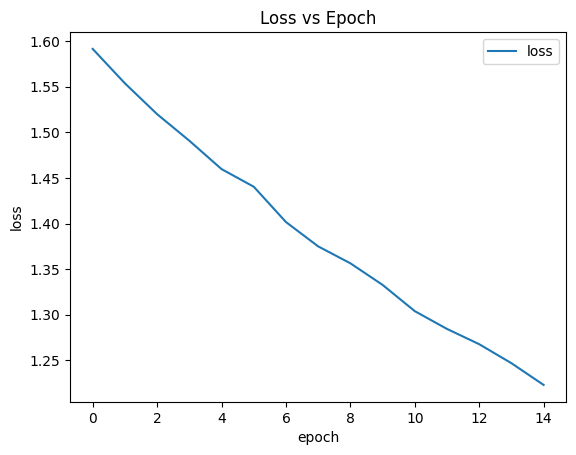

In [55]:
plot_losses(res_losses)
plot_losses(con_res_losses)

In [59]:
testset = TestDataset("data/test_all", transform=basic_transforms)
test_loader = DataLoader(testset, batch_size=128, shuffle=False)

In [65]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
final_model = Model(residual_architectures[0], device)
final_model.load_weights("models/res/model_t_ar_resume.pt")

In [66]:
preds, paths = predict(final_model, test_loader, test=True)

In [67]:
df = pd.DataFrame({"filename": paths, "predictions": preds})
df.to_csv("preds.csv", index=False, header=False)

# Conclusions